![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/regression-part2-automated-ml.png)

# Assignment 2:  Database-based Machine Learning  

In this project, I use a timeseries based Influx database to examine and predict energy demand in Orkney, Scotland.  
The database consists of temperature and weather data as well as operations specific data such as the status of operation across zones.

Having available a dataset of energy demand values raises a central question in energy load forecasting: what is the importance of time with respect to energy demand? 
In answering this question, I expect to find that both seasonal patterns such as month as well as shorter timespans such as time of day will be influential in determining energy demand.

I will be conducting a descriptive analysis of energy demand values in Orkney, mainly with respect to time-based features. 
Continuing from the descriptive domain, I will construct and discuss an implementation of a predictive model for short-term load forecasting based on time-based features. Finally, I consider how to deploy and retrain the forecasting model using Scikit-Learn's Pipeline functionality. 

## 1. Understanding the data

Firstly, I sought to examine the data made available to us in the Influx database.  
In conducting analysis on time-series data, a key insight is the frequency with which new data is added to each of the 7 tables, respectively. 
This information will inform how frequently we can sample data for descriptive and predictive purposes as well as the potential and possible pitfalls of merging data with varying frequencies. 

Each table was queried for all rows and aggregated to compute the count of new records added per hour.

![](https://i.gyazo.com/09ee482843cfc580adf8dc1669f9b572.png)

Here, we see that energy-specific data is added in relatively high frequency (about 40-45 records per hour), whereas weather-related data such as Wind and Temperature is only added a few times a day.   

In effect, if you desire to aggregate data on intervals shorter than an entire day, it needs to be taken into account that there can be intervals within which no weather-related data exists.   

Generally, since records are not structured in a relational fashion in the Influx database, we need to perform joins using time-based keys.

Furtunately, Pandas can perform an [as-of merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html), which is similar to a left-join except that matching occurs on nearest key rather than equal keys. The nearest key is chosen to be a "backwards" search with respect to time such that the 'nearest' data record is the most recent existing record in the dataset.  

Before merging tables, however, further data exploration revealed that the double frequency of Wind records as compared to Temperature records stemmed from the fact that 2 records are added for every timestamp in the Wind table. One record in height 80 and one record in height 10:  

![](https://i.gyazo.com/e28214bcb10b2aab3a6a65b4f453a53d.png)  

Splitting the Wind dataset into 2 filtered versions for each height, I built a method to extract and join data from all tables in the dataset within a set timespan and an aggregate time interval.  

For instance, the method can merge all records within the previous 90 days grouped by 30m time intervals using the following command: 
```
extract_dataset(timespan="90d", groupby_time="30m")
``` 
In order to have an initial 'rough' representation of all features in the database, I chose the aggregate function to be MEAN for continuous variables - such as demand - and MAX for categorical value, such as ANM_Operation for Zone 2B. 

The specific code for this data extraction functionality can be found in attached Python script ```datafunctions.py```.


More importantly, I perform feature engineering on the timestamp values themselves, for which the following features are added: 
* Hour
* Weekday
* Day of month
* Month

With these time-based features, I aimed to represent time-demand patterns on the spectrum of seasonal all the way down to hourly trends.  

Representing such time-based information on a continous scale, however, runs the risk of misrepresenting these features, as they are inherently 'circular'. 

For instance, there might not be a clear increase in energy demand from hour 01 linearly through midnight. On the other hand, we can expect that hour 23 and hour 01 should have similar or correlated demand values, as these hours are "functionally" close. 

This concern was adressed by one-hot encoding time-based features using Pandas' get_dummies() functionality. 

Finally, for simplicity's sake I removed rows with None-values. Analysis of None-values in the dataset is a relevant topic for further work on the Orkney dataset. 

Below, I have chosen to load all data from the previous 1000 days grouped by 30 min intervals with the expectation that both seasonal and hourly patterns are well represented in such a format.

In [3]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [4]:
# import custom method for data extraction
from datafunctions import extract_dataset

In [5]:
# extract all data from previous 1000 days gouped in 30 minute intervals
df = extract_dataset(timespan="1000d", groupby_time="30m")

In [6]:
print("Dataset shape: {}".format(df.shape))
print("The lowest timestamp is {}".format(df.index.min()))

Dataset shape: (20771, 112)
The lowest timestamp is 2018-11-30 21:00:00


Having loaded the dataset into a Pandas DataFrame, I performed a quick inspection of summary statistics for each column using Pandas' .describe() function to ensure that data is represented as intended.  

In [9]:
df.describe().T.sample(25, random_state=1)

,count,mean,std,min,25%,50%,75%,max
month_9,20771.0,0.061047,0.239422,0.000000,0.000000,0.000000,0.000000,1.000000
generation_anm_mean,20771.0,8.176748,6.342627,-5.652000,2.021133,7.027667,14.177567,20.979132
hour_0,20771.0,0.041885,0.200332,0.000000,0.000000,0.000000,0.000000,1.000000
month_11,20771.0,0.069616,0.254505,0.000000,0.000000,0.000000,0.000000,1.000000
hour_20,20771.0,0.041693,0.199891,0.000000,0.000000,0.000000,0.000000,1.000000
v,20771.0,1.947902,6.741531,-18.976755,-2.903984,2.398292,6.875298,23.798428
shepd_equipment_zone_4_max,20771.0,0.001589,0.039828,0.000000,0.000000,0.000000,0.000000,1.000000
hour_10,20771.0,0.041693,0.199891,0.000000,0.000000,0.000000,0.000000,1.000000
day_30,20771.0,0.027298,0.162953,0.000000,0.000000,0.000000,0.000000,1.000000
day_5,20771.0,0.035338,0.184636,0.000000,0.000000,0.000000,0.000000,1.000000


Above, summary statistics of 40 randomly samples features are displayed. There are 3 important considerations to take note of in the above statistics: 
* The dataset contains 20771 records beginning 2018-11-30 21:00:00
* The majority of features are binary/categorical 
* There are no clear outlier values amongst the numeric features such as wind speed and generation mean. 
* The mean values for one-hot encoded time features correspong to the expected values. E.g. the mean hour_8 is 0.04, which is exactly 1/24.

Having a dataset consisting of time-based categorical features combined with numeric values for energy demand allows for a deeper understanding of the relationship between time and demand.

## 2. Descriptive analysis

In describing the effect of time on energy demand in isolation, I chose to filter out all non-time related features except energy demand from the extracted Pandas DataFrame. 

In [12]:
time_features = ['hour', 'day', 'month', 'weekday']
time_columns = [col for col in df.columns if col.split("_")[0] in time_features]
df_only_time = df[time_columns + ['demand_total_mean']]

Next, I chose to model inspect the linear correlation between time and energy demand across all time-based features. 
I used Pandas' .corr() method to compute the linear Person correlation between each time-based feature and energy demand:

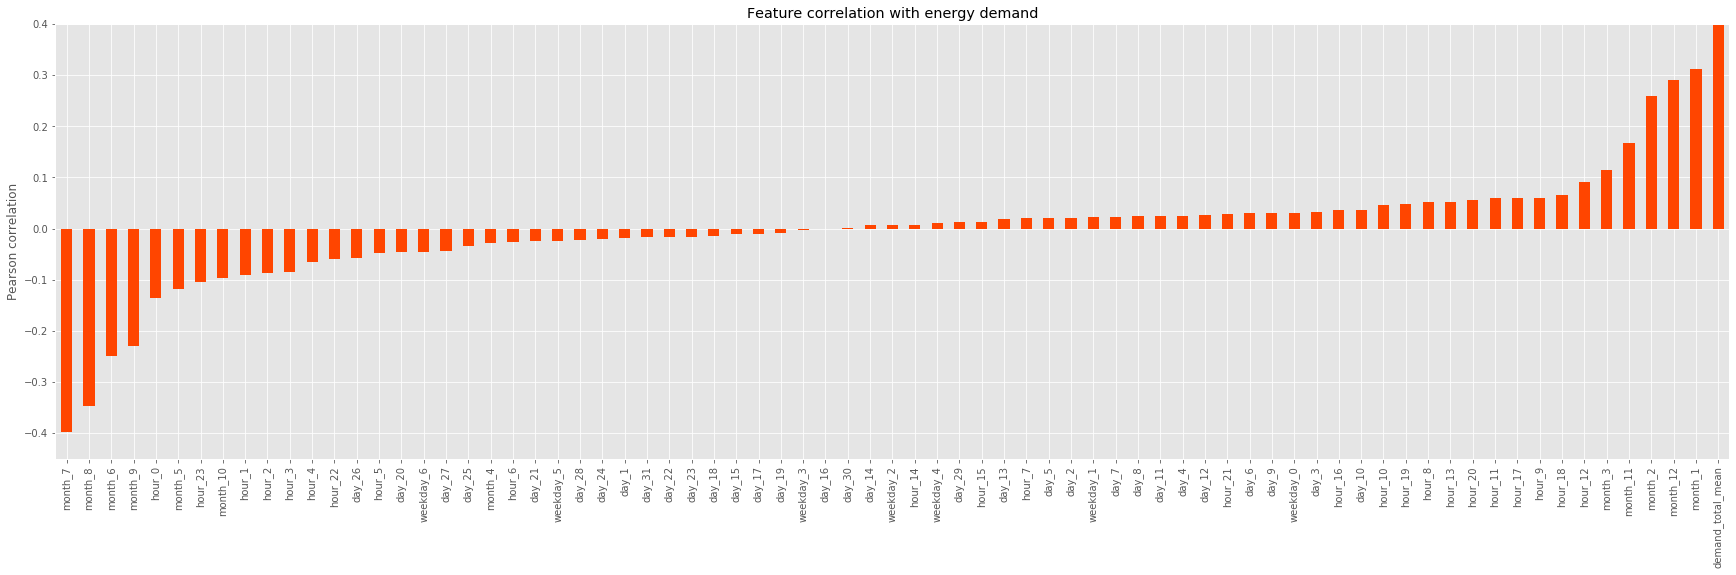

In [13]:
df_only_time.corr(method='pearson').demand_total_mean.sort_values().plot(kind='bar', figsize=(30, 8), 
                                                                         ylim=(-0.45, 0.4), 
                                                                         title="Feature correlation with energy demand",
                                                                         color='orangered')
plt.ylabel('Pearson correlation')
plt.show()

These correlations reveal several trends relevant for evaluating the effect of time on energy demnand:
* The winter months (month 11,12,1,2) are positively correlated with energy demand, whereas the summer months (month 6, 7, 8, & 9) have a similar negative correlation with energy demand. 
* Seasonal/monthly features have the strongest linear correlation with energy demand
* The hours 9, 12 and 18 have the highest positive correaltion to energy demand. It seems fair to assume that we can explain this correlation by the times of day most frequently used to prepare food, which is often an energy-intensive task.  
* Interestingly, no single weekday has a significant linear correlation, neither positive nor negative, with energy demand.   
 
It should be noted that the above findings are solely reflective of the linear relationships between time and demand. More complex non-linear correlations patterns can be captured by non-linear machine learning models. 

One approach to mapping non-linear relationships between time-based featuers and demand is using a decision tree regression model.  
Here, each feature is ranked with respect to impurity, e.g. the ability to separate data into distinctive bins.     
The Scitkit-Learn DecisionTreeRegressor has a convenient abstraction to extract features by their importance.


As I am still in the descriptive domain,I train a Decision Tree Regressor on the entire dataset used above to compute linear correlations

In [14]:
df_time_copy = df_only_time.copy()

y_df = df_time_copy.pop("demand_total_mean")
x_df = df_time_copy

In [15]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(x_df, y_df)
print("The R2 score on the training dataset is {}".format(regressor.score(x_df, y_df)))

The R2 score on the training dataset is 0.9886258864457685


The Decision Tree regressor has a coefficient of determination of $R^2 = 0.98$. As a perfect regressor would achieve $R^2 = 1.0$, this value implyies that the decision tree is heavily overfit to training data. As it is solely used for descriptive purposes, however, overfitting is not a decifiancy in this particular model. 

Next, I use Scikit-Learn's API to extract each feature in their order of importance based on Gini impurity: 

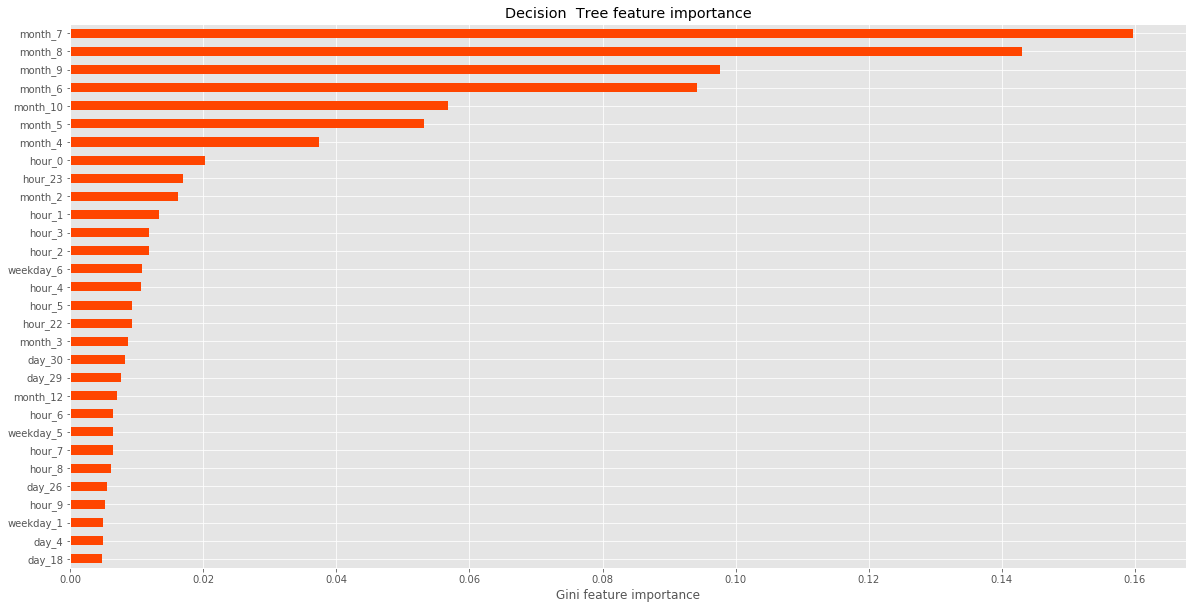

In [16]:
feature_order = x_df.columns
feature_importance = regressor.feature_importances_
# store feature-importance mapping in Pandas Series
feature_imp_series = pd.Series(feature_importance, index=feature_order)

# plot top 20 features by importance
feature_imp_series.sort_values(ascending=True).tail(30).plot(kind='barh', figsize=(20, 10), 
                                                             title="Decision  Tree feature importance",
                                                             color='orangered')
plt.xlabel('Gini feature importance')
plt.show()

Contrary to a Person correlation, the Gini feature importance is not reflective of its corespondence to particular trends in demand values. E.g. a high feature importance is neither associated with high nor low demand values.  

Instead, the value is reflective of how important the feature is in terms of *dividing* the data into the set of bins most descriptive of demand.  

With this in mind, the above values for the most part reveal a pattern similar to the Person correlation; Seasonal/monthly features are of highest importance and the months 6-9 are of particularly high importance.  
In other words, energy demand is lower in warmer seasons.  

Similarly, we can see that hours from 23-05 are of high importance, which we know are associated with low energy demand.  

Lastly, we can observe that weekdays 5 and 6 (corresponding to Saturday and Sunday) are of higher importance compared to other weekdays. Person correlations revealed that these weekdays are also associated with lower energy demand. 

## 3. Predictive modelling

Descriptive analysis revealed that linear as well as non-linear models capture similar features in the dataset, thought the decision tree classifier assigns particularly high importance to features associated with low energy demand.  
Had I chosen to represent time as continuous variables, I could have expected highly non-linear patterns to emerge in the dataset, though is is certainly less clear what is most appropriate in the one-hot-encoded representation.   

One possible solution is to try out both options; a linear regressor and a tree-based regressor.  

Additionally, in a predictive domain it is relevant to have a baseline model to use for benchmarking.  
For this purpose, I beging by constructing a persistence model which uses the latest (backwards) Demand value as the prediction.   

When constructing such a model, is critical that not to perform any shuffling of the data, as succesive data points will contribute to the persistence model's predictions.

In [18]:
import numpy as np
from sklearn.metrics import r2_score

def predict_persistence(y_values, shift=1):
    """
    Predicts the observed value at <shift> timesteps backwards .  
    Predicts true value for the first <shift> observations
    """
    y_list = y_values.flatten().tolist()
    return np.array( y_list[:shift] + y_list[0:-shift] )

In [19]:
predict_persistence(np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8]), shift=2)

array([0.2, 0.3, 0.2, 0.3, 0.4, 0.5, 0.6])

I evaluate the persistence model with respect to time shifts from 0.5 hour to 5 hours in order to examine how the persistence model performs in various forecasting tasks. 

In [22]:
# test persistence model on test dataset with shift of 1, 2 and 3 
for i in range(1, 11, 1):
    print("Persistence model with shift = {} has an R2-score of {} on the training dataset"
          .format(i, r2_score(y_df.values, predict_persistence(y_df.values, shift=i))))

Persistence model with shift = 1 has an R2-score of 0.9480628641486852 on the training dataset
Persistence model with shift = 2 has an R2-score of 0.8894508111751265 on the training dataset
Persistence model with shift = 3 has an R2-score of 0.8321824750017366 on the training dataset
Persistence model with shift = 4 has an R2-score of 0.7879126719879233 on the training dataset
Persistence model with shift = 5 has an R2-score of 0.7474321258837084 on the training dataset
Persistence model with shift = 6 has an R2-score of 0.7009529114848849 on the training dataset
Persistence model with shift = 7 has an R2-score of 0.659083345212891 on the training dataset
Persistence model with shift = 8 has an R2-score of 0.6290956500133051 on the training dataset
Persistence model with shift = 9 has an R2-score of 0.5970066118252219 on the training dataset
Persistence model with shift = 10 has an R2-score of 0.5709655898392882 on the training dataset


The persistence model is able to achieve a rather high $R^2$-value of 0.94 when it simply samples the previous value (shift = 1).  
This should expected given that our data is generated on a 30min interval and our 'lowest' level of time granualrity is hourly.     

On the other hand, the fact that it is not perfect (1.0) suggests that there is still some variation in demand values within each half/full hour.  

We can also observe that the performance of the persistance model quite significantly decreases with each timestep, i.e. going back 1.5 hours rather than 30 minutes decreases $R^2$ from 0.94 to 0.83.  
This suggests that the persistence model performs well as a predictive model on very short-term forecasting, especially within the first 2-3 hours. 

Having a baseline model, I trained a linear regression classifier on the dataset to test if the linear correlations are adequate for demand forecasting.  

Ordinary least squares Linear Regression is conveniently implemented in Scikit-Learn's LinearRegression model.   

Firstly, however, I created a train-test split to evaluate model performance on unseen data. Scikit-Learn's train_test_split() method provides functionality to do so taking Pandas DataFrames as input.   

Below, I use Scikit-Learn to ensure that data is not shuffled in the train-test split, in order to ensure that both development and holdout data is unseen in training. 

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# store first 16000 records for training and development splits, the rest for holdout dataset
holdout_cutoff = 16000
traindev_dataset = df_only_time.iloc[:holdout_cutoff]
holdout_dataset = df_only_time.iloc[holdout_cutoff:]

def get_train_dev_split(dataset, rate_dev=0.25):
    
    df = dataset.copy()
    y_df = df.pop("demand_total_mean")
    x_df = df
    
    x_train, x_dev, y_train, y_dev = train_test_split(x_df, y_df, test_size=rate_dev, random_state=42, shuffle=False)

    return x_train, x_dev, y_train, y_dev

x_train, x_dev, y_train, y_dev = get_train_dev_split(traindev_dataset, rate_dev=0.15)

Next, I fit and evaluate a simple ordinary least squares regressor using $R^2$-score as the evaluation metric.

In [26]:
linreg = LinearRegression(fit_intercept=True)
linreg.fit(x_train, y_train)

print("Linear regression model has an R2-score of {} on the validation dataset".format(r2_score(y_dev.values, linreg.predict(x_dev))))
print("Linear regression model has an R2-score of {} on the training dataset".format(r2_score(y_train.values, linreg.predict(x_train))))

Linear regression model has an R2-score of 0.2570009363554968 on the validation dataset
Linear regression model has an R2-score of 0.7777099258734591 on the training dataset


With the linear regression model trained on the entire dataset, I saw a significant gap in performance between training and test data, even for a simple model such as OLS regression, which is typically not prone to overfitting.  

The rather high $R^2$-score on the training data suggests that purely time-based features can indeed be used to model energy demand to a reasonable extent.

The poor performance on the validation dataset, however, suggests that there is information in the timespan covered by the development data which the trained model is unable to capture. To examine further, I display the regressors estimations on the development data compared to a an ideal model.

In [27]:
def plot_regression_results(y_pred, y_true, title="Regression predictions"):
    
    plt.figure(figsize=(20, 12))
    
    min_ = min(y_true) - 0.2
    max_ = max(y_true) + 0.2
    
    r2 = r2_score(y_true, y_pred)
    
    plt.plot([min_, max_], [min_, max_], linestyle='dashed', label='Perfect fit')
    plt.scatter(y_true, y_pred, c='#2b8cbe', alpha=0.5, label='Predictions')
    plt.title('{}: \n$R^2={:.4}$'.format(title, r2))
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.legend(loc='best')
    
    plt.show()

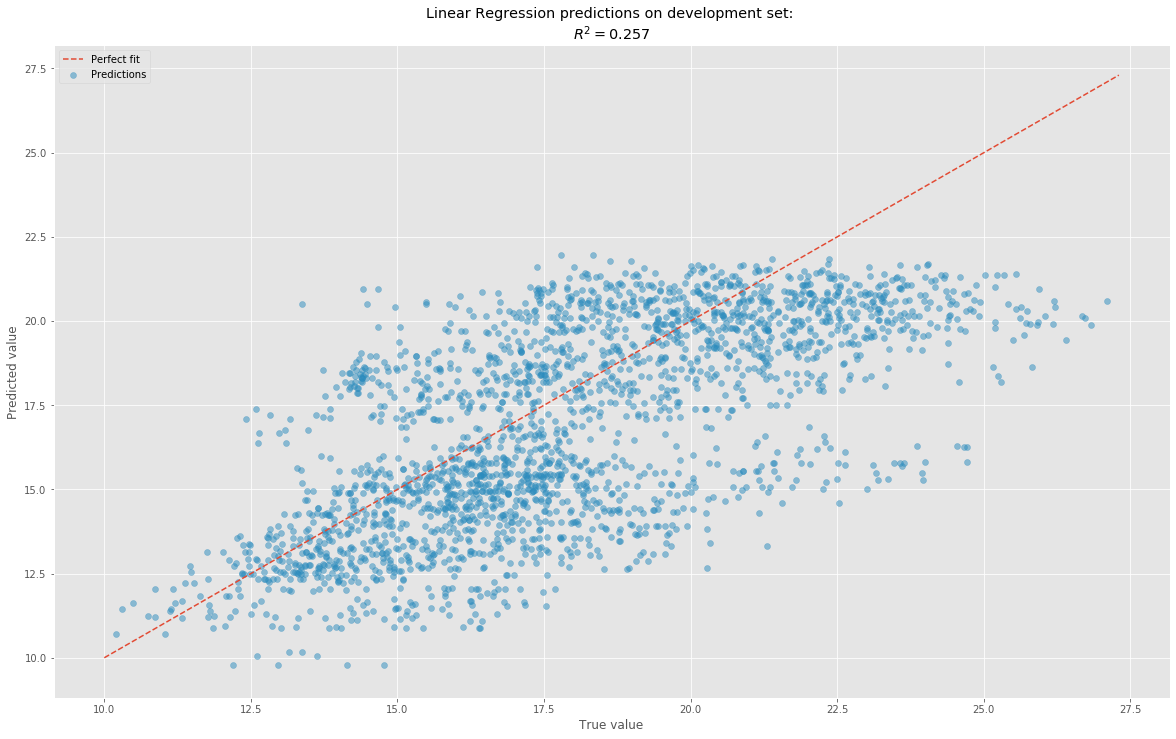

In [28]:
plot_regression_results(linreg.predict(x_dev), y_dev.values, "Linear Regression predictions on development set")

Above, we see that the linear regression model generally under-estimates demand; the majority of predictions are below the ideal fit, suggesting that the model has high bias in the direction of low demand. A possible explanation might be that the model is mostly trained on data from warmer seasons, yet is evaluated only on data in a cold season.   

This claim is easily verified by inspecting the timespans covered by training and development data respectively.

In [126]:
print("Timespan in training data: {} to {}".format(x_train.index.min(), x_train.index.max()))
print("Timespan in development data: {} to {}".format(x_dev.index.min(), x_dev.index.max()))

Timespan in training data: 2018-11-30 21:00:00 to 2019-10-08 06:00:00
Timespan in development data: 2019-10-08 06:30:00 to 2019-11-27 06:30:00


Indeed, we see that the development data occurs in a seasonal timeframe which the training data does not capture. Specifically, most development data occurs in October and November, whereas the training data captures the months December to October.  

In case the model was trained on muliple years (e.g. a decade) of training data, I could expect to be better able to capture all seasons in trained models.  

I chose to address this issue while still maintaining the strong seasonal patterns in energy demand by continously training regressors only on recent demand data.  
In other words, when making predictions of demand in early February, I only want to train the model on data from the January and perhaps December.   

Testing this approach requires a method to extrat short-term training and test data samples. Below, I define a method to extract training and test data for a given set of days (default 7 test days and 14 training days) from a given maximum date.

In [31]:
from dateutil.parser import parse
from datetime import timedelta


def get_shortterm_data_split(dataframe, max_test_date, test_days=7, training_days=14):
    """
    Returns test-train split of given dataframe with test data up t6 bot exclusive of max_test_date
        dataframe: Pandas DataFrame with time-features
        max_test_date: Datetime
        test_days: number of days covered by test dataset
        training_days: number of days covered by training dataset
    Removes day and month-columns from the dataset
    """
    
    # remove all day and month columns 
    df = dataframe[[col for col in dataframe.columns if 'day' not in col and 'month' not in col]]
    
    # compute minimum test date and minimum training data date
    min_test_date = max_test_date - timedelta(days=test_days)
    min_train_date = min_test_date - timedelta(days=training_days)
    
    # filter dataframe by datetime index
    test_data = df.loc[min_test_date:max_test_date]
    train_data = df.loc[min_train_date:min_test_date]
    
    return test_data, train_data

Next, it is convenient to have a method to fit, predict and evaluate short-term predictions. Fortunately, the Scikit-Learn API makes it easy to do so in very few lines of code: 

In [36]:
def fit_predict_shortterm(clf, train_data, dev_data, verbose=True):
    """
    Fits, predicts and evaluates an Sklearn classifier on training and development data
        clf: Sklearn classifier
        train_data: Pandas dataframe
        dev_data: Pandas dataframe
        verbose: If True, prints R2-score on val. and dev. datasets
    """
    target = 'demand_total_mean'
    
    # extract input and target data for train and dev.
    x_train = train_data.drop(columns=[target])
    y_train = train_data[target]
    
    x_dev = dev_data.drop(columns=[target])
    y_dev = dev_data[target]
    
    # fit classifier to training data
    clf.fit(x_train, y_train)
    
    # predict development and training data target values
    y_hat_dev = clf.predict(x_dev)
    y_hat_train = clf.predict(train_data.drop(columns=[target]))

    if verbose:
        print("R2-score on validation dataset: {:.4}".format(r2_score(y_dev, y_hat_dev)))
        print("R2-score on training dataset: {:.4}".format(r2_score(y_train, y_hat_train)))
        
    return y_hat_dev, y_dev, y_hat_train, y_train

Finally, I test the above functionality on a train-test split of 14 training days followed by 7 test days ending on date 2019-10-01.  

I use the same OLS linear regressor as earlier for comparison with the previous predictive model.

R2-score on validation dataset: 0.6618
R2-score on training dataset: 0.4352
R2-score of persistence model (2 hour shift) on the validation dataset: 0.33191007160425523


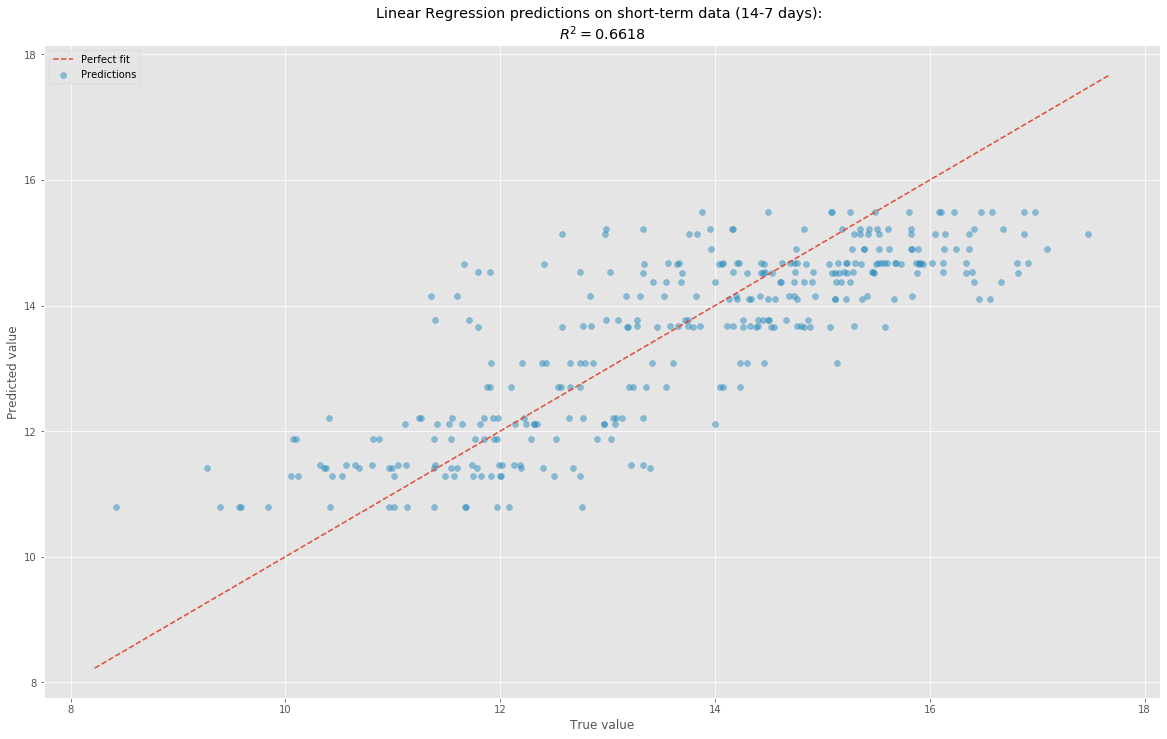

In [65]:
test_shortterm, train_shortterm = get_shortterm_data_split(traindev_dataset, parse('2019-10-01'), 7, training_days=14)

linreg_short = LinearRegression(fit_intercept=True)
y_hat_dev, y_dev, y_hat_train, y_train = fit_predict_shortterm(linreg_short, train_shortterm, test_shortterm, verbose=True)
print("R2-score of persistence model (2 hour shift) on the validation dataset: {}"
      .format(r2_score(y_dev, predict_persistence(y_dev.values, shift=4))))

plot_regression_results(y_hat_dev, y_dev, "Linear Regression predictions on short-term data (14-7 days)")

This approach yielded vastly different results to training on the entire dataset. Rather than characteristics of overfitting, we see a higher predictive performance on the unseen test data compared to the performance on training data. Furthermore, even a simple OLS linear regressor achieves $R^2=0.65$ on 7 days of unseen data, which is superior to the persistence model which always predicts the value observed just 2 hours prior. 

The regression visualisation reveals that the regressor continues to have a noticable variance, yet the bias observed in the general model is non-existant here, as predictions are scattered evenly around the perfect fit.

Indeed, these results suggest that using a small but recent training dataset is a superior approach for the dataset available in this project. 

With a vastly smaller dataset it is not unreasonable to expect more variation in the performance of short-term models, as outliers and noise will have more importance in the final model. It is relevant to test over a sliding train-test data split if the above performance is a trend rather than a convenient accident for the specific dates chosen. 

For this purpose, I define a function which concatenates predictions over sliding short-term train-test splits across the entire training dataset. 

In [48]:
def sliding_predictions(dataset, clf, predict_days=7, train_days=14):
    """
    Fits and evaluates a classifier across sliding train-test splits
    over given dataset
        dataset: Pandas dataframe
        clf: Sklearn classifier
        predict_days: number of days for test/prediction
        train_days: number of days for training dataset split
    """
    
    # compute upper and lower bound dates
    min_date = parse(str(min(dataset.index)))
    max_date = parse(str(max(dataset.index)))
    diff_days = (max_date - min_date).days
    
    # initialize the number of days to add to min date
    date_add = predict_days + train_days
    
    predictions = None
    true_values = None
    
    # continue until the maximum days reached
    while date_add < diff_days:
        
        # get train-test data split with max date date_add + min_date 
        test_shortterm, train_shortterm = get_shortterm_data_split(dataset, min_date + timedelta(date_add), 
                                                                   predict_days, training_days=train_days)
        
        # If there is any test data, fit and predict classifier
        if test_shortterm.shape[0] > 0:

            y_hat_dev, y_dev, y_hat_train, y_train = fit_predict_shortterm(clf, train_shortterm, test_shortterm, verbose=False)
            
            # store predictions and true values
            if predictions is None:
                predictions = y_hat_dev
                true_values = y_dev
            else:
                predictions = np.concatenate((predictions, y_hat_dev), axis=0)
                true_values = np.concatenate((true_values, y_dev), axis=0)
        
        # update date_add
        date_add += predict_days
    
    return predictions, true_values

Next, I train a OLS linear regressor on the sliding short-term data splits with 7 days test and 14 days training:

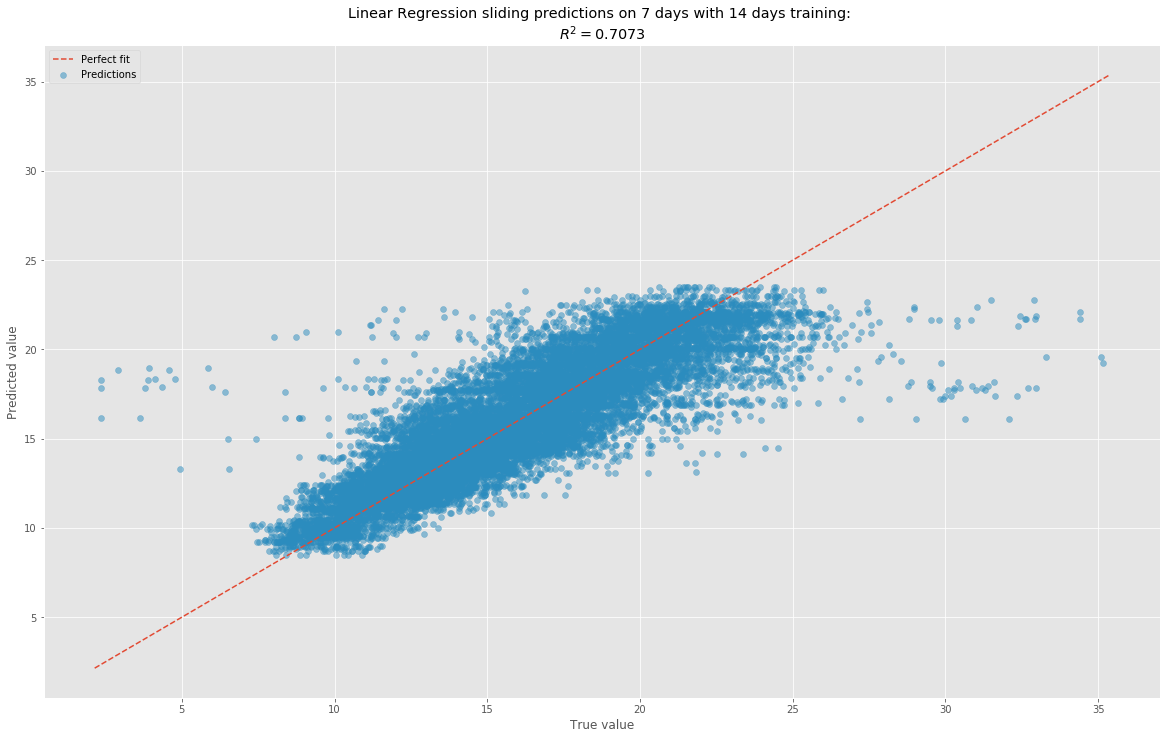

In [49]:
linreg_short = LinearRegression(fit_intercept=True)
sliding_preds, sliding_true_values = sliding_predictions(traindev_dataset, linreg_short, predict_days=7, train_days=14)
plot_regression_results(sliding_preds, sliding_true_values, "Linear Regression sliding predictions on 7 days with 14 days training")

Indeed, the performance of this short-term forecasting approach is generally superior to the predictive model trained on the entire dataset, achieving a combined $R^2=0.7073$ as opposed to $R^2=0.25$.  

Furthermore, a random forest classifier can be easily evaluated in a similar fashion to test if we see an improvement by capturing non-linearity in the data:

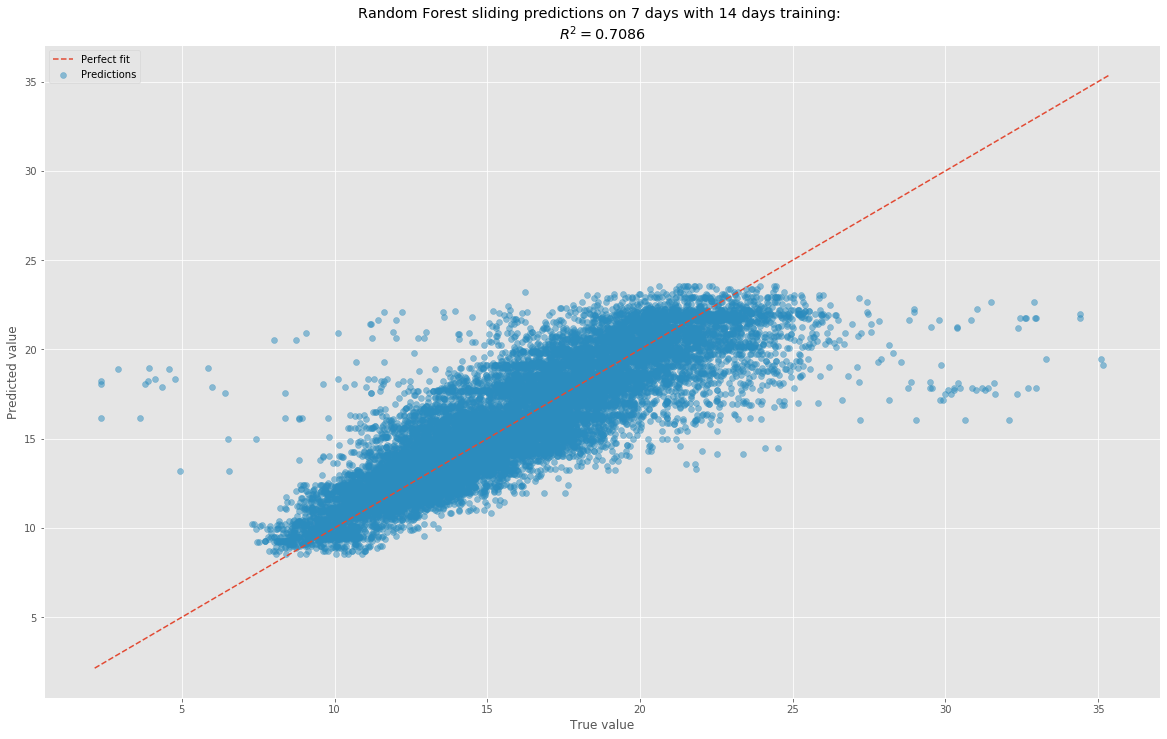

In [56]:
from sklearn.ensemble import RandomForestRegressor
forest =  RandomForestRegressor(random_state=42, n_estimators=15, bootstrap=True)
sliding_preds, sliding_true_values = sliding_predictions(traindev_dataset, forest, predict_days=7, train_days=14)
plot_regression_results(sliding_preds, sliding_true_values, "Random Forest sliding predictions on 7 days with 14 days training")

Above, we find that the random forest classifier is only marginally better than a simple OLS regressor with $R^2=0.7086$. It suggests that one-hot encoding time-based features eliminates most of the nonlinearity introduced by representing time in a numeric fashion.  

More importantly, the performance of both models suggest that demand/load forecasting, at least on a short term, is best achieved by using temporally close training data. As a result, each individual classifier will only perform well on data on a reasonably small forecasting timeframe, e.g. 1 week.


## Deployment  

Knowing an appropriate approach for training classifiers for load forecasting, it is convenient to tailor the training process for a deployment setup which is easily implemented in cloud-based or local environments. 

One approach is to set up a webservice which can return load predictions for a given list of datetime objects. This way the end-user is relieved of the trouble in converting datetime-objects to a one-hot encoded representation used as input to classifiers. 

On the server side, the administrator needs to ensure 2 processes: Data transformation and prediction.
Scikit-Learns Pipeline API provides an excellent framework for defining both steps in one wrapped instance.  

Firstly, I define a method which converts a string-format datetime object into the one-hot time-based featureset used by the classifiers trained above:

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from dateutil.parser import parse
    
from sklearn.preprocessing import FunctionTransformer



def get_time_features(X):
    """
    Converts datetime (string) into input vector
     X: string. datetime, e.g. "2019-01-01 15:30:00"
    """
    
    from dateutil.parser import parse
    import pandas as pd
    
    # represent input in DF
    df = pd.DataFrame(X, columns=['time'])
    
    time_features = ['hour', 'weekday']
    
    # extract hour and weekday from X
    df['hour'] = df.apply(lambda x: pd.Series(parse(str(x.time)).hour, index=['hour']), axis=1)
    df['weekday'] = df.apply(lambda x: pd.Series(parse(str(x.time)).weekday(), index=['weekday']), axis=1)

    # define all possible columns for hour and weekday features
    one_hot_features = ['hour_' + str(i) for i in range(0, 24)] + ['weekday_' + str(i) for i in range(0, 7)]
    
    # one-hot encode X
    df = pd.get_dummies(df, columns=time_features)
    
    # add all one-hot features not added by get_dummies() with value 0
    missing_features = [feature for feature in one_hot_features if feature not in df.columns]
    df[missing_features] = pd.DataFrame([[0]*len(missing_features)], index=df.index)

    # ensure that column order corresponds to training data
    df = df[one_hot_features]

    return df

alt_transformer = FunctionTransformer(get_time_features, validate=False)

Next, I test if the custom data transformer works as intended:

In [58]:
test_input = ['2019-01-01 15:30:00', '2019-02-06 00:10:00']

In [329]:
alt_transformer.transform(test_input)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Now that I have a custom data transformer, I can initialize a Scikit-Learn Pipeline with a random forest classifer applied after data preprocessing:

In [59]:
from sklearn.pipeline import Pipeline
from joblib import dump, load
forest =  RandomForestRegressor(random_state=42, n_estimators=15, bootstrap=True)
pipe = Pipeline([('transform_time', alt_transformer), ('forest', forest)])

The entire pipeline can now be trained on the most recent 2 weeks of training data from the Demand table.  
I use the ```query_pd()``` method to send database queries to the Influx database and return results as a Pandas DataFrame. 

In [60]:
from influxdb import InfluxDBClient

def query_pd(query):
    client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
    client.switch_database('orkney')
    
    results = client.query(query) # Query written in InfluxQL
    points = results.get_points()
    
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index)
    return df

In [61]:
two_weeks_demand = query_pd('SELECT mean(Total) FROM "Demand" WHERE time > now() - {}d GROUP BY time(30m)'.format(14))
two_weeks_demand_times = [str(time_stamp) for time_stamp in two_weeks_demand.index]
two_weeks_demand_target = two_weeks_demand['mean'].values

# fit and store Sklearn pipeline
pipe.fit(two_weeks_demand_times, two_weeks_demand_target)
dump(pipe, 'demand_pipeline.job')

['demand_pipeline.job']

Now that the entire pipeline is trained and stored in a single file, deployment to a web service is straightforward.   

For instance, the prediction can be served using a simple Flask app either locally or on a Cloud compute service such as MS Azure.  
As an example, I have deployed the model shown above on [pythonanywhere.com](https://www.pythonanywhere.com/)

![](https://i.gyazo.com/a6f6c3936d6b8b061a42c5797a042f26.png)

We can now test the simple deployment scheme by sending a POST request to my custom endpoint:

In [62]:
import requests

r = requests.post('https://brikals.pythonanywhere.com/demand_prediction/', 
                  json={"data":  ["2019-01-01 15:30:00", "2019-02-06 18:10:00"]})

r.json()

{'data': ['2019-01-01 15:30:00', '2019-02-06 18:10:00'],
 'predictions': [17.840964708994708, 20.256594814814814]}

Cloud services such as [Microsoft Azure](https://azure.microsoft.com/en-in/services/machine-learning/) provide additional functionality train, store and deploy Scikit-learn models in a scheduled, streamlined fashion with support for version control, distributed computing and more.  

### Retraining

As the classifier is heavily dependent on temporally close data, it should be retrained frequently, for instance daily. 
Thanks to the convenience of Scikit-Learn's Pipeline API, retraining the model is simply a matter of scheduling an execution of the code used to extract and train a Pipeline: 

In [63]:
from joblib import dump, load

def retrain_pipeline(num_days):

    two_weeks_demand = query_pd('SELECT mean(Total) FROM "Demand" WHERE time > now() - {}d GROUP BY time(30m)'.format(num_days))
    two_weeks_demand_times = [str(time_stamp) for time_stamp in two_weeks_demand.index]
    two_weeks_demand_target = two_weeks_demand['mean'].values

    forest =  RandomForestRegressor(random_state=42, n_estimators=15, bootstrap=True)
    pipe = Pipeline([('transform_time', alt_transformer), ('forest', forest)])
    
    pipe.fit(two_weeks_demand_times, two_weeks_demand_target)
    
    dump(pipe, 'demand_pipeline.job')
    
    return pipe

In [64]:
retrain_pipeline(num_days=14)

Pipeline(memory=None,
     steps=[('transform_time', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function get_time_features at 0x7f10d8704620>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('forest', RandomForestRegressor(bootstr...imators=15, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

A more sophisticated retraining setup should also take performance into account in order to prevent training a model on irregular or missing data, which might yield poor performance.

## Conclusion 

Through descriptive analysis, I found that time should be considered an essential feauture in load forecasting. Time-based features are correlated with demand on both seasonal (monthly) and hourly levels.   
For predictive purposes, I found that the it was not suitable to train a generalized model on all temporal features with the dataset available, as it only goes back to the end of 2018. Rather, a superior approach proved to be to train short-term load forecasters on temporally close data (e.g. 2 weeks), thus training only on seasonal behaviour.   

Finally, I showed how Scikit-Learn's Pipeline API makes it easy to deploy and retrain forecasting models using a webservice such as Python Flask.